# In-silico derivatization

The notebook reads a list of SMILES (text file, one molecule per line), and performs in-silico MeOX + TMS derivatization (as described e.g. in https://doi.org/10.1021/acs.analchem.7b01010):

* Metoxymation: ketone R(C=O)R' and aldehyde karboxyl groups are substituted with C=NO[CH3]
* Trimethylsilylation: in -OH, -SH, -NH2, -NHR, =NH, the hydrogen is substituted with -SiMe3

The probability of all the substitutions can be adjusted, they needn't happen always. Multiple substitution attempts are run on each input molecule, and all distinct results are returned.

Known limitation is metoxymation on cycles which should be broken. This is not implemented yet.

The final outputs are two files:

* `derivs_struct.tsv` with columns (all SMILES):
  * original
  * with derivatization groups stripped
  * column #2 derivatized (multiple times) according to the above rules
* `derivs_flat.txt` -- the above with all the smiles flattened, one per line



### Import what we need and setup the environment

In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem
#from rdkit.Chem.Draw import IPythonConsole
from copy import deepcopy
import random

#IPythonConsole.drawOptions.addAtomIndices = True
#IPythonConsole.molSize = 200,200

random.seed(42)

import multiprocessing
from concurrent.futures import ProcessPoolExecutor
cpus = multiprocessing.cpu_count()
print('# cpus (including HT, typically): ', cpus)

# don't run on HT cores, it just makes congestion
cpus //= 2
print(cpus)

# cpus (including HT, typically):  8
4


In [4]:
# import our payload
from gc_meox_src import is_derivatized, remove_derivatization_groups, add_derivatization_groups

### Utility function for 3D rendering

In [5]:
import py3Dmol

def draw3d(m,dimensions=(500,300),p=None):
    AllChem.EmbedMultipleConfs(m, clearConfs=True, numConfs=50)
    opt =  AllChem.MMFFOptimizeMoleculeConfs(m)
    conf = min(range(len(opt)),key = lambda x: opt[x][1] if opt[x][0] == 0 else float("inf") )
    
    mb = Chem.MolToMolBlock(m,confId=conf)
    if p is None:
        p = py3Dmol.view(width=dimensions[0],height=dimensions[1])
    p.removeAllModels()
    p.addModel(mb,'sdf')
    p.setStyle({'stick':{}})
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    return p.show()


### Simple checks on manual inputs

In [ ]:
for s in ['CCC(=NOC)C', 'CCC=NOC', 'C=NOC', 'CSi(C)(C)C']:
    print(s,is_derivatized(smiles='CCC(=NOC)C'))

In [ ]:
remove_derivatization_groups(smiles='CCC(=N)C')

In [ ]:
m=Chem.MolFromSmiles('CCC=NOC')
remove_derivatization_groups(m)

In [ ]:
remove_derivatization_groups(smiles='C[Si](C)(C)OCCCO[Si](C)(C)C')

In [ ]:
m=remove_derivatization_groups(smiles='CON=CC(O)C=NOC')
m

In [ ]:
add_derivatization_groups(m)

### Read the input file

The file is parsed line by line, errors are reported and ignored otherwise. 

The result is `mol[]`, a list of pairs (_original SMILES_, _RDKit molecule_)

In [8]:
#smi_file='NIST_Si_100.txt'
#smi_file='NIST_Si_all.txt'
#smi_file='NIST_SMILES.txt'
filename = 'NIST_195_200.txt'
def read_input_file(filename):
    smi_file = filename
    with open(smi_file) as f:
        mols = list(filter(lambda p: p[1], [ (smi.rstrip(), Chem.MolFromSmiles(smi)) for smi in f ]))
        return mols

read_input_file(filename)

[('CC(=O)N([Si](C)(C)C)[Si](C)(C)C',
  <rdkit.Chem.rdchem.Mol at 0x7f0bea017100>),
 ('C[C@@H]1CO1', <rdkit.Chem.rdchem.Mol at 0x7f0bea0171c0>)]

### Essential statistics

Count occurrences of (one-),di-,tri-methylsilane, TMS attached to -O, -N, -S, and methoximine. 

In [41]:
num_of_subs = {
    "SiMe1" : Chem.MolFromSmarts('[Si][CH3]'),
    "SiMe2" : Chem.MolFromSmarts('[Si]([CH3])[CH3]'),
    "SiMe3" : Chem.MolFromSmarts('[Si]([CH3])([CH3])[CH3]'),
    "ONSSi" : Chem.MolFromSmarts('[O,N,S][Si]([CH3])([CH3])[CH3]'),
    "MeOX"  : Chem.MolFromSmiles('CC1CO1')
}

print('# total',len(read_input_file(filename)))

with_sime1 = list(filter(lambda m: m[1].HasSubstructMatch(num_of_subs['SiMe1']),read_input_file(filename)))
print("# with SiMe1:", len(with_sime1))

with_sime2 = list(filter(lambda m: m[1].HasSubstructMatch(num_of_subs['SiMe2']),read_input_file(filename)))
print("# with SiMe2:", len(with_sime2))

with_sime3 = list(filter(lambda m: m[1].HasSubstructMatch(num_of_subs['SiMe3']),read_input_file(filename)))
print("# with SiMe3:", len(with_sime3))

with_onssi = list(filter(lambda m: m[1].HasSubstructMatch(num_of_subs['ONSSi']),read_input_file(filename)))
print("# with ONSSi:", len(with_onssi))

with_meox = list(filter(lambda m: m[1].HasSubstructMatch(num_of_subs['MeOX']),read_input_file(filename)))
print("# with MeOX:", len(with_meox))

# total 2
# with SiMe1: 1
# with SiMe2: 1
# with SiMe3: 1
# with ONSSi: 1
# with MeOX: 1


### Inspect whatever from the sorted categories

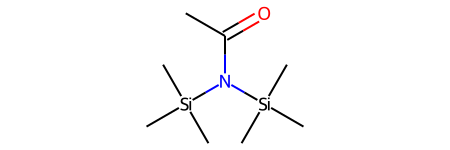

In [25]:

with_sime1[0][1]

In [30]:
draw3d(with_sime3[0][1])

[21:53:02] Molecule does not have explicit Hs. Consider calling AddHs()
[21:53:02] Molecule does not have explicit Hs. Consider calling AddHs()


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [31]:
draw3d(with_onssi[0][1])

[21:53:09] Molecule does not have explicit Hs. Consider calling AddHs()
[21:53:09] Molecule does not have explicit Hs. Consider calling AddHs()


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

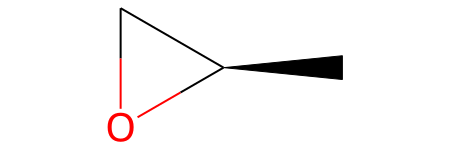

In [32]:
with_meox[0][1]


In [33]:
draw3d(with_meox[0][1])

[21:53:22] Molecule does not have explicit Hs. Consider calling AddHs()
[21:53:22] Molecule does not have explicit Hs. Consider calling AddHs()


ValueError: Bad Conformer Id

In [34]:
with open('NIST_ONSSiMe3.txt','w') as f:
    for m in with_onssi:
        f.write(m[0]+'\n')
        
with open('NIST_SiMe3.txt','w') as f:
    for m in with_sime3:
        f.write(m[0]+'\n')
        
with open('NIST_MeOX.txt','w') as f:
    for m in with_meox:
        f.write(m[0]+'\n')

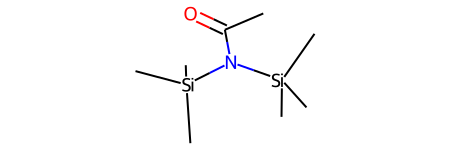

In [36]:
#test_smi='CCO[Si](C)(C)C'
#test_smi='C[Si](C)(C)OCC-N[Si](C)(C)C'
#test_m = Chem.MolFromSmiles(test_smi)
test_m = with_onssi[0][1]
Chem.AddHs(test_m)
test_m

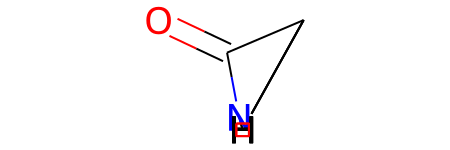

In [37]:
test_n = remove_derivatization_groups(test_m)
Chem.AddHs(test_n)

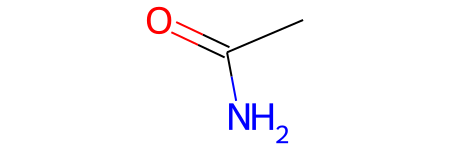

In [38]:
test_d = add_derivatization_groups(test_n)
test_d

In [39]:
draw3d(test_d)

[21:56:53] Molecule does not have explicit Hs. Consider calling AddHs()
[21:56:53] Molecule does not have explicit Hs. Consider calling AddHs()


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Run the in-silico derivatization

Iterate over the `mol[]` list (read from file above), remove derivatization groups from each entry, and try derivatization several times to leverage from the probabilistic behaviour). Assemble the results.

This can be time consuming, expect about 5,000 entries per minute per core. Memory consumption can also grow to several GB.

In [ ]:
%%time
def process_one_mol(mol):
    return (
        mol[0],
        Chem.MolToSmiles(remove_derivatization_groups(mol[1])),
        { Chem.MolToSmiles(add_derivatization_groups(mol[1])) for _ in range(42) }
        )

def num_cpu():
    random.seed(42)
    cpus = multiprocessing.cpu_count()
    print('# cpus (including HT, typically): ', cpus)
    cpus //= 2
            
def process_pool_exe(filename):
    with ProcessPoolExecutor(max_workers=num_cpu()) as executor:
        out = executor.map(process_one_mol,read_input_file(filename))
        return out
    
type(out)

### Write the main outputs

In [ ]:
with open('derivs_struct.tsv','w') as tsv:
    tsv.write("orig\tderiv. removed\tderiv. added ...\n")
    for orig,removed,added in process_pool_exe(filename):
        tsv.write("\t".join([orig,removed,*added]) + "\n")

In [ ]:
with open('derivs_flat.txt','w') as flat:
    for orig,removed,added in out:
        for one in { orig, removed, *added }:
            flat.write(one + "\n")